In [1]:
%load_ext autoreload
%autoreload 2


from IPython.display import display, HTML
from agents import banditagents
from environments import bandits
import utils

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
sns.set_theme(style="whitegrid", palette="pastel")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##  Run Solvers

In [5]:
configs_dir = '/Users/juliomartinez/Documents/PhD/socialmotivation/configs'
num_episodes = 500

solvers = ['GreedyAgent', 'EpsilonGreedyAgent']
environment = 'TwoArmBandit'

bandit_config_filename = os.path.join(configs_dir, environment + '.yaml')
bandit_config = utils.get_config(bandit_config_filename)
env = bandits.Bandit(bandit_config)
num_iterations = 1000

results_column_names = ['episode','iteration','solver','reward_demonstrator','reward_learner','chosen_arm_id_demonstrator','chosen_arm_id_learner']
#results_column_name = ['episode', 'iteration', 'solver', 'agent', 'reward', 'best_arm_id']
#best_arm_dist_column_names = ['solver', 'num_episodes', 'num_iterations', 'prob_arm1', 'prob_arm2']


for i, solver in enumerate(solvers):
 
    # Get solver class 
    agentClass = getattr(banditagents, solver)
    
    # Get config file
    agents_config_filename = os.path.join(configs_dir, solver + '.yaml')
    agents_config = utils.get_config(agents_config_filename)

    demonstrator_best_arm_distribution = np.zeros(env.num_arms)
    learner_best_arm_distribution = np.zeros(env.num_arms)

    for episode_j in range(num_episodes):
        # run demonstrator
        demonstrator = agentClass(agents_config['demonstrator'])   
        demonstrator(env)
        
        # run learner
        learner = agentClass(agents_config['learner'])
        learner(env, demonstrator)

        # store results
        demonstrator_best_arm_distribution[demonstrator.best_arm_id]=+1
        learner_best_arm_distribution[learner.best_arm_id]=+1

        num_iterations = len(demonstrator.reward_history)
        iterations = list(range(num_iterations))
        episodes = [episode_j]*num_iterations
        solvers_ = [solver]*num_iterations
        trial_df = pd.DataFrame(list(zip(episodes, iterations, solvers_, demonstrator.reward_history,learner.reward_history, demonstrator.arm_id_history, learner.arm_id_history)), columns=results_column_names)
        if i < 1 and episode_j < 1:
            results_df = trial_df.copy()
        else:
            results_df = pd.concat([results_df,trial_df],join='inner', ignore_index=True)

    demonstrator_best_arm_distribution = demonstrator_best_arm_distribution / np.sum(demonstrator_best_arm_distribution)
    learner_best_arm_distribution = learner_best_arm_distribution / np.sum(learner_best_arm_distribution)
    solver_df = pd.DataFrame({
        'solver':solver, 
        'num_episodes': num_episodes, 
        'num_iterations': num_iterations, 
        'demonstrator_prob_arm0':demonstrator_best_arm_distribution[0],
        'demonstrator_prob_arm1':demonstrator_best_arm_distribution[1], 
        'learner_prob_arm0':learner_best_arm_distribution[0],
        'learner_prob_arm1':learner_best_arm_distribution[1]
        }, index=[0])
    if i < 1:
        arm_dist_df = solver_df.copy()
    else:
        arm_dist_df = pd.concat([arm_dist_df,solver_df],axis=0)

results_df.to_csv('/Users/juliomartinez/Documents/PhD/socialmotivation/results.csv')
display(HTML(results_df.head().to_html()))

,episode,iteration,solver,reward_demonstrator,reward_learner,chosen_arm_id_demonstrator,chosen_arm_id_learner
0,0,0,GreedyAgent,1.0,1.0,0,0
1,0,1,GreedyAgent,0.0,0.0,1,0
2,0,2,GreedyAgent,0.0,1.0,1,0
3,0,3,GreedyAgent,1.0,0.0,1,0
4,0,4,GreedyAgent,1.0,0.0,1,0


## Compute Helper Variables

In [6]:
# Add cumulative reward (over iterations) to results_df
results_df = pd.read_csv('/Users/juliomartinez/Documents/PhD/socialmotivation/results.csv', index_col=0)
results_df['cumulative_reward_demonstrator'] = results_df.groupby(['solver','episode'])['reward_demonstrator'].cumsum()
results_df['cumulative_reward_learner'] = results_df.groupby(['solver','episode'])['reward_learner'].cumsum()

# Compute average cumulative reward (average across episodes)
#avg_cumulative_reward_df['avg_cumulative_reward_demonstrator'] = results_df.groupby(['solver','iteration'])['cumulative_reward_demonstrator'].mean()
#avg_cumulative_reward_df['avg_cumulative_reward_learner'] = results_df.groupby(['solver','iteration'])['cumulative_reward_learner'].mean()
avg_cumulative_reward_demonstrator = pd.Series(results_df.groupby(['solver','iteration'])['cumulative_reward_demonstrator'].mean(), name='avg_cumulative_reward_demonstrator')
avg_cumulative_reward_learner = pd.Series(results_df.groupby(['solver','iteration'])['cumulative_reward_learner'].mean(), name='avg_cumulative_reward_learner')
avg_cumulative_reward_df = pd.concat([avg_cumulative_reward_demonstrator,avg_cumulative_reward_learner],axis=1)
avg_cumulative_reward_df['delta_of_avg_cumulative_reward'] = avg_cumulative_reward_df['avg_cumulative_reward_learner'].sub(avg_cumulative_reward_df['avg_cumulative_reward_demonstrator'], axis = 0)
avg_cumulative_reward_df

delta_df = results_df[['episode', 'iteration', 'solver']]
delta_df['delta_of_cumulative_reward'] = results_df['cumulative_reward_learner'].sub(results_df['cumulative_reward_demonstrator'], axis = 0)
results_df.head()


print('\n\nResults')
display(HTML(results_df.head().to_html()))

print('\n\nAverge Cumulative Reward')
display(HTML(avg_cumulative_reward_df.head().to_html()))

print('\n\nDelta of Each Iteration')
display(HTML(delta_df.head().to_html()))




Results


/var/folders/60/0s86_8k10s944d057gz21wzh0000gn/T/ipykernel_14742/242840569.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_df['delta_of_cumulative_reward'] = results_df['cumulative_reward_learner'].sub(results_df['cumulative_reward_demonstrator'], axis = 0)


,episode,iteration,solver,reward_demonstrator,reward_learner,chosen_arm_id_demonstrator,chosen_arm_id_learner,cumulative_reward_demonstrator,cumulative_reward_learner
0,0,0,GreedyAgent,1.0,1.0,0,0,1.0,1.0
1,0,1,GreedyAgent,0.0,0.0,1,0,1.0,1.0
2,0,2,GreedyAgent,0.0,1.0,1,0,1.0,2.0
3,0,3,GreedyAgent,1.0,0.0,1,0,2.0,2.0
4,0,4,GreedyAgent,1.0,0.0,1,0,3.0,2.0




Averge Cumulative Reward




Delta of Each Iteration


,episode,iteration,solver,delta_of_cumulative_reward
0,0,0,GreedyAgent,0.0
1,0,1,GreedyAgent,0.0
2,0,2,GreedyAgent,1.0
3,0,3,GreedyAgent,0.0
4,0,4,GreedyAgent,-1.0


## Format Data for Visualization

In [7]:
results_long_df = pd.wide_to_long(
    results_df, 
    stubnames=['reward', 'chosen_arm_id', 'cumulative_reward'], 
    i=['episode', 'iteration', 'solver'], 
    j='agent',
    sep='_', 
    suffix=r'\w+')
print('Results Pivot Longer')
display(HTML(results_long_df.head().to_html()))

Results Pivot Longer


## Display Plots

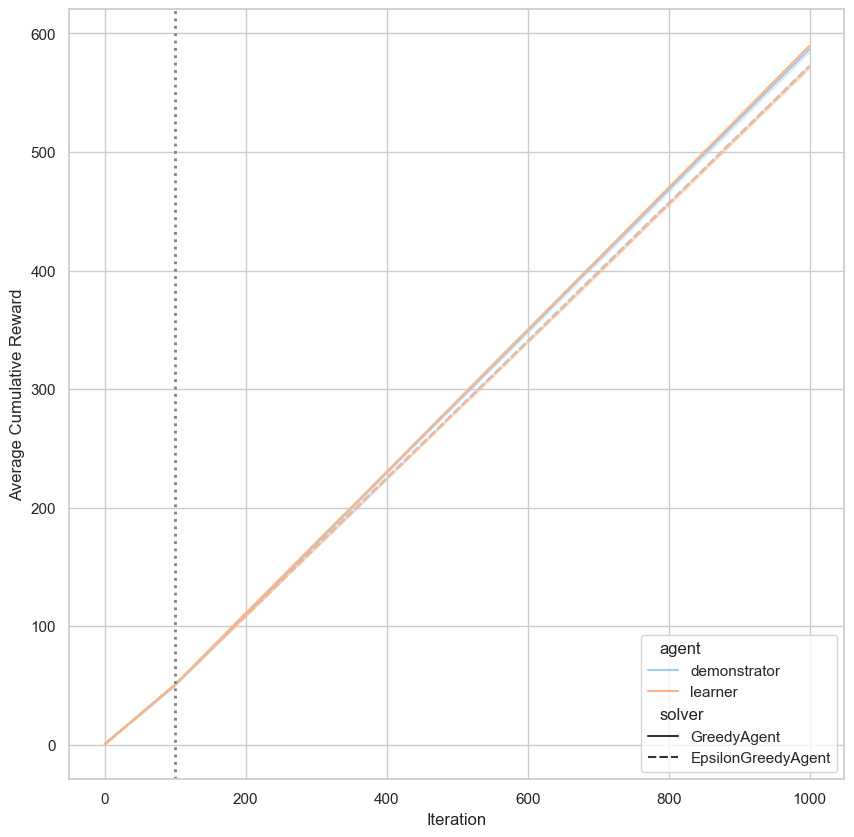

In [8]:
fig = plt.subplots(figsize=(10,10))
sns.lineplot(data=results_long_df, x="iteration", y="cumulative_reward", hue="agent", style="solver")
plt.ylabel('Average Cumulative Reward')
plt.xlabel('Iteration')
plt.axvline(x=100, ls=':', lw=2, label='number of initial iterations', color='grey')
plt.show()

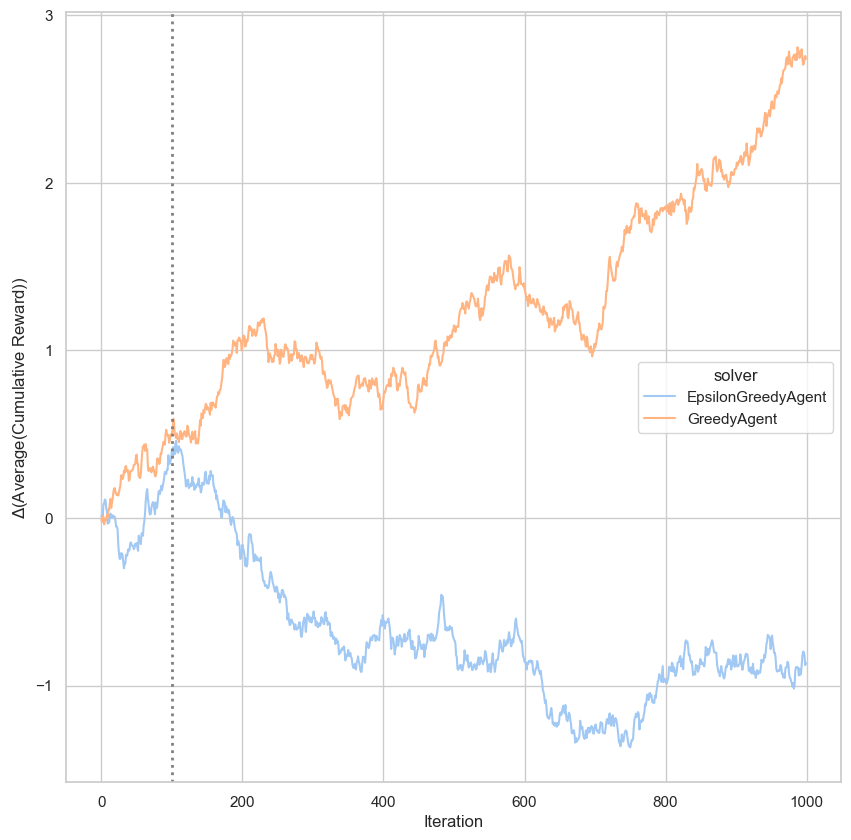

In [9]:
fig = plt.subplots(figsize=(10,10))
sns.lineplot(data=avg_cumulative_reward_df, x="iteration", y="delta_of_avg_cumulative_reward", hue="solver")
plt.ylabel('$\Delta$(Average(Cumulative Reward))')
plt.xlabel('Iteration')
plt.axvline(x=100, ls=':', lw=2, label='number of initial iterations', color='grey')
plt.show()

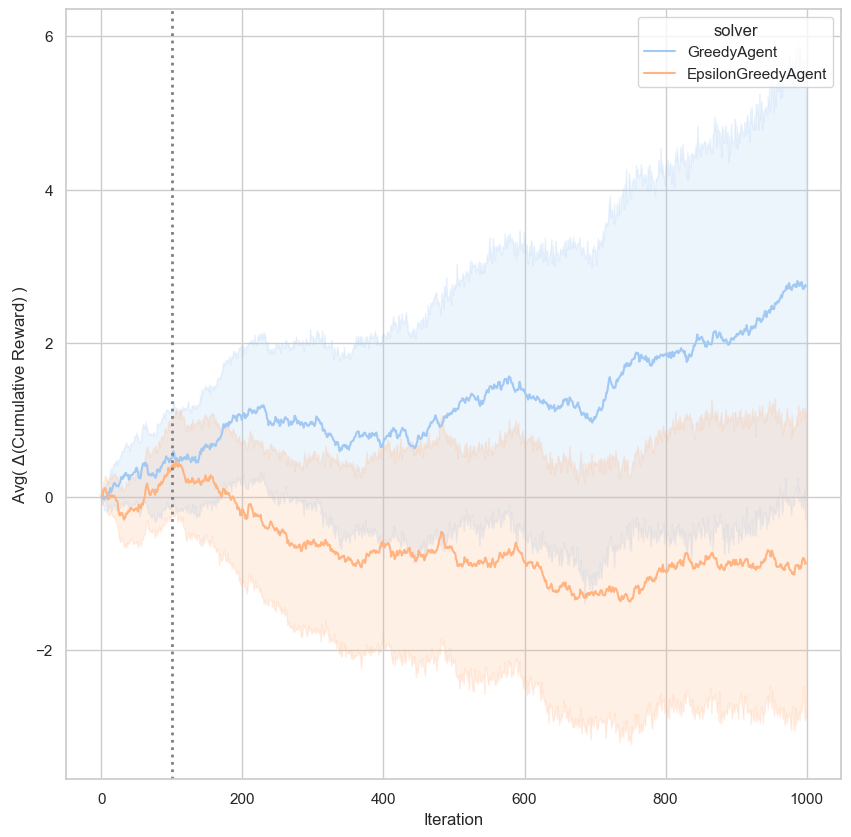

In [10]:
#color_palette = sns.color_palette("flare")
fig = plt.subplots(figsize=(10,10))
sns.lineplot(data=delta_df, x="iteration", y="delta_of_cumulative_reward", hue="solver")
plt.ylabel('Avg( $\Delta$(Cumulative Reward) )')
plt.xlabel('Iteration')
plt.axvline(x=100, ls=':', lw=2, label='number of initial iterations', color='grey')
plt.show()